In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

path="D://Téléchargement//QueryResults.csv"

data=pd.read_csv(path)

Fonctions de nettoyage de texte

In [2]:
data=data[:5000]
# Tokenizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
data_T=data.loc[:,['Title','Body','Tags']]

def tokenizer_fct(sentence) :
    sentence_clean = sentence.replace('+', 'plus').replace('/', ' ').replace('#', 'sharp')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@"))
                                       and (not w.startswith("http"))]
    return lw


# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def noun_extract(text):
    tokens = nltk.word_tokenize(text)
    tags_pos = nltk.pos_tag(tokens)
    nouns = [word for word,pos in tags_pos if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
    return(' '.join(nouns).lower())

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    nouns=noun_extract(desc_text)
    word_tokens = tokenizer_fct(nouns)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    nouns=noun_extract(desc_text)
    word_tokens = tokenizer_fct(nouns)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    nouns=noun_extract(desc_text)
    word_tokens = tokenizer_fct(nouns)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

In [4]:
data_T['Body'] =data_T['Title'] + ' ' + data_T['Body']
datacopy=data_T.copy()

In [5]:
data_T

,Title,Body,Tags
0,Heap corruption under Win32; how to locate?,Heap corruption under Win32; how to locate? <p...,<c++><windows><multithreading><debugging><memory>
1,Rails: How to set a background image in rails ...,Rails: How to set a background image in rails ...,<css><ruby-on-rails><ruby-on-rails-3><ruby-on-...
2,Create a directly-executable cross-platform GU...,Create a directly-executable cross-platform GU...,<python><user-interface><deployment><tkinter><...
3,How do I make event callbacks into my win form...,How do I make event callbacks into my win form...,<c#><.net><winforms><multithreading><events>
4,Pandas OHLC aggregation on OHLC data,Pandas OHLC aggregation on OHLC data <p>I unde...,<python><python-2.7><pandas><dataframe><resamp...
...,...,...,...
4995,Entity Framework Code First Fluent Api: Adding...,Entity Framework Code First Fluent Api: Adding...,<c#><entity-framework-4><ef-code-first><data-a...
4996,IIS Returning Old User Names to my application,IIS Returning Old User Names to my application...,<asp.net><security><iis><authentication><kerbe...
4997,"AtomicReferenceFieldUpdater - methods set, get...","AtomicReferenceFieldUpdater - methods set, get...",<java><concurrency><volatile><atomicreference>...
4998,how to return json encoded form errors in symfony,how to return json encoded form errors in symf...,<php><ajax><json><forms><symfony>


In [6]:
import re
listebalise=['<p>','</p>','<pre>','</pre>','<code>','</code>','<strong>','</strong>','<em>','</em>','<mark>','</mark>','<ul>','</ul>','<ol>','</ol>','<br>','\n','<blockquote>','</blockquote>']
for k in range(len(data_T)):
    result_test=re.split('<code>(.*)</code>',datacopy['Body'][k])
    if len(result_test)==1:
        datacopy['Body'][k]=result_test[0]
    else:
        datacopy['Body'][k]=' '.join([result_test[2*i] for i in range(len(result_test)//2)])
    result_test=re.split('<li>(.*)</li>',datacopy['Body'][k])
    if len(result_test)==1:
        datacopy['Body'][k]=result_test[0]
    else:
        datacopy['Body'][k]=' '.join([result_test[2*i] for i in range(len(result_test)//2)])
    temp=datacopy['Body'][k]
    for i in listebalise:
        temp=temp.replace(i," ")
    data_T['Body'][k]=temp

In [7]:
data_T

,Title,Body,Tags
0,Heap corruption under Win32; how to locate?,Heap corruption under Win32; how to locate? I...,<c++><windows><multithreading><debugging><memory>
1,Rails: How to set a background image in rails ...,Rails: How to set a background image in rails ...,<css><ruby-on-rails><ruby-on-rails-3><ruby-on-...
2,Create a directly-executable cross-platform GU...,Create a directly-executable cross-platform GU...,<python><user-interface><deployment><tkinter><...
3,How do I make event callbacks into my win form...,How do I make event callbacks into my win form...,<c#><.net><winforms><multithreading><events>
4,Pandas OHLC aggregation on OHLC data,Pandas OHLC aggregation on OHLC data I unders...,<python><python-2.7><pandas><dataframe><resamp...
...,...,...,...
4995,Entity Framework Code First Fluent Api: Adding...,Entity Framework Code First Fluent Api: Adding...,<c#><entity-framework-4><ef-code-first><data-a...
4996,IIS Returning Old User Names to my application,IIS Returning Old User Names to my application...,<asp.net><security><iis><authentication><kerbe...
4997,"AtomicReferenceFieldUpdater - methods set, get...","AtomicReferenceFieldUpdater - methods set, get...",<java><concurrency><volatile><atomicreference>...
4998,how to return json encoded form errors in symfony,how to return json encoded form errors in symf...,<php><ajax><json><forms><symfony>


In [8]:
data_T['sentence_bow'] = data_T['Body'].apply(lambda x : transform_bow_fct(x))
data_T['sentence_bow_lem'] = data_T['Body'].apply(lambda x : transform_bow_lem_fct(x))
data_T['sentence_dl'] = data_T['Body'].apply(lambda x : transform_dl_fct(x))

In [9]:
from collections import Counter
def tokenizer_fct_tags(sentence) :
    sentence_clean = sentence.replace('<', ' ').replace('>', ' ').replace('+', 'plus')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens


data_T['tags']=data['Tags'].apply(lambda x : tokenizer_fct_tags(x))


list_of_tags = []
for item in data_T['tags']:
    for word in item:
        if not word in list_of_tags:
            list_of_tags.append(word)


list_of_all_tags = []
for item in data_T['tags']:
    for word in item:
        list_of_all_tags.append(word)

In [10]:
data_T

,Title,Body,Tags,sentence_bow,sentence_bow_lem,sentence_dl,tags
0,Heap corruption under Win32; how to locate?,Heap corruption under Win32; how to locate? I...,<c++><windows><multithreading><debugging><memory>,heap corruption win32 cplusplus application he...,heap corruption win32 cplusplus application he...,heap corruption win32 cplusplus application he...,"[cplusplus, windows, multithreading, debugging..."
1,Rails: How to set a background image in rails ...,Rails: How to set a background image in rails ...,<css><ruby-on-rails><ruby-on-rails-3><ruby-on-...,rails background image rails css rails backgro...,rail background image rail cs rail background ...,rails background image rails css rails i backg...,"[css, ruby-on-rails, ruby-on-rails-3, ruby-on-..."
2,Create a directly-executable cross-platform GU...,Create a directly-executable cross-platform GU...,<python><user-interface><deployment><tkinter><...,cross-platform gui app python python platforms...,cross-platform gui app python python platform ...,cross-platform gui app python python platforms...,"[python, user-interface, deployment, tkinter, ..."
3,How do I make event callbacks into my win form...,How do I make event callbacks into my win form...,<c#><.net><winforms><multithreading><events>,event callbacks win forms event object form co...,event callback win form event object form cont...,event callbacks win forms event object form co...,"[c, #, .net, winforms, multithreading, events]"
4,Pandas OHLC aggregation on OHLC data,Pandas OHLC aggregation on OHLC data I unders...,<python><python-2.7><pandas><dataframe><resamp...,pandas ohlc aggregation ohlc data ohlc re-samp...,panda ohlc aggregation ohlc data ohlc re-sampl...,pandas ohlc aggregation ohlc data ohlc re-samp...,"[python, python-2.7, pandas, dataframe, resamp..."
...,...,...,...,...,...,...,...
4995,Entity Framework Code First Fluent Api: Adding...,Entity Framework Code First Fluent Api: Adding...,<c#><entity-framework-4><ef-code-first><data-a...,entity framework code first fluent api adding ...,entity framework code first fluent api adding ...,entity framework code first fluent api adding ...,"[c, #, entity-framework-4, ef-code-first, data..."
4996,IIS Returning Old User Names to my application,IIS Returning Old User Names to my application...,<asp.net><security><iis><authentication><kerbe...,iis returning old user names application scena...,ii returning old user name application scenari...,iis returning old user names application scena...,"[asp.net, security, iis, authentication, kerbe..."
4997,"AtomicReferenceFieldUpdater - methods set, get...","AtomicReferenceFieldUpdater - methods set, get...",<java><concurrency><volatile><atomicreference>...,atomicreferencefieldupdater methods semantics ...,atomicreferencefieldupdater method semantics h...,atomicreferencefieldupdater methods semantics ...,"[java, concurrency, volatile, atomicreference,..."
4998,how to return json encoded form errors in symfony,how to return json encoded form errors in symf...,<php><ajax><json><forms><symfony>,json errors symfony webservice form case error...,json error symfony webservice form case error ...,json errors symfony webservice form case error...,"[php, ajax, json, forms, symfony]"


In [11]:
counts = Counter(list_of_all_tags)
l2=list_of_tags.copy()
for k in l2:
    for i in list_of_tags:
        if k in i and k!=i and len(k)>2:
            counts[k]+=counts[i]
            counts[i]=0
            list_of_tags.remove(i)

In [12]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]

data2 = data_T.sentence_bow.values.tolist()
data_words = list(sent_to_words(data2))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['heap', 'corruption', 'win', 'cplusplus', 'application', 'heap', 'tools', 'corruption', 'old', 'builds', 'months', 'source', 'code', 'behaviour', 'release', 'time', 'downside', 'source', 'deltas', 'bug', 'lot', 'code', 'changes', 'repository', 'prompt', 'behaviuor', 'throughput', 'system', 'socket', 'transfer']


In [13]:
datawords=[]
for k in data_words:
    datawords+=k

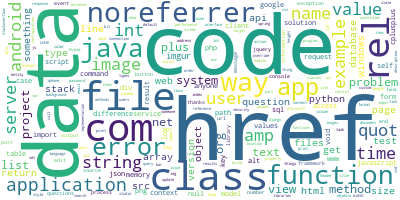

In [14]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = Counter(datawords)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate_from_frequencies(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [15]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 2), (17, 5), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 4)]


In [16]:
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=20, limit=60, step=5)

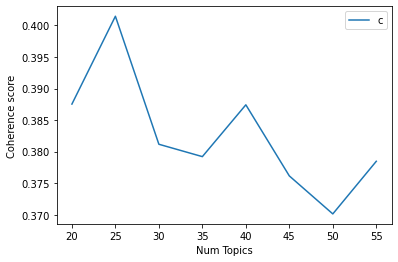

In [17]:
limit=60; start=20; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [18]:
from pprint import pprint
# number of topics
num_topics = start+np.argmax(coherence_values)
print('Number of topics : ' + str(num_topics))
# LDA model
lda_model = model_list[np.argmax(coherence_values)]
# Print the Keyword in the topics
pprint(lda_model.print_topics())

doc_lda = lda_model[corpus]



Number of topics : 21
[(20,
  '0.011*"data" + 0.010*"way" + 0.009*"code" + 0.007*"class" + 0.007*"div" + '
  '0.007*"href" + 0.007*"system" + 0.007*"function" + 0.006*"string" + '
  '0.006*"table"'),
 (6,
  '0.011*"net" + 0.011*"com" + 0.010*"image" + 0.008*"asp" + 0.007*"view" + '
  '0.007*"application" + 0.006*"mvc" + 0.006*"web" + 0.006*"class" + '
  '0.006*"href"'),
 (24,
  '0.008*"int" + 0.008*"code" + 0.008*"data" + 0.007*"server" + 0.006*"app" + '
  '0.006*"class" + 0.006*"user" + 0.005*"href" + 0.005*"function" + '
  '0.005*"file"'),
 (23,
  '0.008*"data" + 0.008*"string" + 0.008*"list" + 0.007*"file" + 0.007*"way" + '
  '0.006*"log" + 0.006*"value" + 0.006*"app" + 0.006*"user" + 0.006*"type"'),
 (1,
  '0.009*"image" + 0.009*"file" + 0.008*"href" + 0.007*"rel" + 0.007*"com" + '
  '0.007*"size" + 0.007*"noreferrer" + 0.006*"function" + 0.006*"class" + '
  '0.006*"name"'),
 (3,
  '0.012*"href" + 0.012*"rel" + 0.011*"noreferrer" + 0.008*"name" + '
  '0.007*"model" + 0.006*"code" +

In [19]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = " ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

C:\Users\antoi\AppData\Local\Temp\ipykernel_3524\4095888859.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\antoi\AppData\Local\Temp\ipykernel_3524\4095888859.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7,0.9896,href code noreferrer rel app com file image ar...,"[heap, corruption, win, cplusplus, application..."
1,1,7,0.4924,href code noreferrer rel app com file image ar...,"[rails, background, image, rails, css, rails, ..."
2,2,13,0.7737,java file href noreferrer rel image data com o...,"[cross, platform, gui, app, python, python, pl..."
3,3,11,0.5928,java class code name org href problem data mes...,"[event, callbacks, win, forms, event, object, ..."
4,4,22,0.9098,href class java page application com noreferre...,"[pandas, ohlc, aggregation, ohlc, data, ohlc, ..."
5,5,19,0.9200,file href code function class app line error c...,"[something, firebug, javascript, javascript, b..."
6,6,5,0.9740,android app com href file way rel string user ...,"[wia, version, vista, scan, paperless, filing,..."
7,7,21,0.9200,quot error href time file com string user net ...,"[core, dump, linux, segmentation, fault, proce..."
8,8,14,0.9700,code data class error way application function...,"[subversion, repository, number, code, way, ve..."
9,9,9,0.5175,href view com text noreferrer problem rel code...,"[symbol, file, custom, project, visual, studio..."


In [20]:
data_T['keywords_bow']=df_dominant_topic['Keywords']

In [21]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_T['sentence_bow_lem'])
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

C:\Users\antoi\AppData\Local\Temp\ipykernel_3524\4095888859.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\antoi\AppData\Local\Temp\ipykernel_3524\4095888859.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


In [22]:
data_T['keywords_bow_lem']=df_dominant_topic['Keywords']

In [23]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_T['sentence_dl'])
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
data_T['keywords_dl']=df_dominant_topic['Keywords']

C:\Users\antoi\AppData\Local\Temp\ipykernel_3524\4095888859.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\antoi\AppData\Local\Temp\ipykernel_3524\4095888859.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


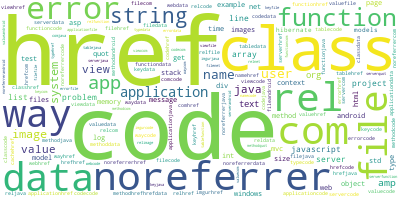

In [24]:
# Join the different processed titles together.
long_string = ''.join(list(data_T['keywords_bow_lem'].values))
long_string=Counter(long_string.split(sep=' '))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate_from_frequencies(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [25]:
data_T

,Title,Body,Tags,sentence_bow,sentence_bow_lem,sentence_dl,tags,keywords_bow,keywords_bow_lem,keywords_dl
0,Heap corruption under Win32; how to locate?,Heap corruption under Win32; how to locate? I...,<c++><windows><multithreading><debugging><memory>,heap corruption win32 cplusplus application he...,heap corruption win32 cplusplus application he...,heap corruption win32 cplusplus application he...,"[cplusplus, windows, multithreading, debugging...",href code noreferrer rel app com file image ar...,href code noreferrer rel app com file image ar...,href code noreferrer rel app com file image ar...
1,Rails: How to set a background image in rails ...,Rails: How to set a background image in rails ...,<css><ruby-on-rails><ruby-on-rails-3><ruby-on-...,rails background image rails css rails backgro...,rail background image rail cs rail background ...,rails background image rails css rails i backg...,"[css, ruby-on-rails, ruby-on-rails-3, ruby-on-...",href code noreferrer rel app com file image ar...,android app com href file way rel string user ...,android app com href file way rel string user ...
2,Create a directly-executable cross-platform GU...,Create a directly-executable cross-platform GU...,<python><user-interface><deployment><tkinter><...,cross-platform gui app python python platforms...,cross-platform gui app python python platform ...,cross-platform gui app python python platforms...,"[python, user-interface, deployment, tkinter, ...",java file href noreferrer rel image data com o...,java file href noreferrer rel image data com o...,java file href noreferrer rel image data com o...
3,How do I make event callbacks into my win form...,How do I make event callbacks into my win form...,<c#><.net><winforms><multithreading><events>,event callbacks win forms event object form co...,event callback win form event object form cont...,event callbacks win forms event object form co...,"[c, #, .net, winforms, multithreading, events]",java class code name org href problem data mes...,java class code name org href problem data mes...,java class code name org href problem data mes...
4,Pandas OHLC aggregation on OHLC data,Pandas OHLC aggregation on OHLC data I unders...,<python><python-2.7><pandas><dataframe><resamp...,pandas ohlc aggregation ohlc data ohlc re-samp...,panda ohlc aggregation ohlc data ohlc re-sampl...,pandas ohlc aggregation ohlc data ohlc re-samp...,"[python, python-2.7, pandas, dataframe, resamp...",href class java page application com noreferre...,href class java page application com noreferre...,href class java page application com noreferre...
...,...,...,...,...,...,...,...,...,...,...
4995,Entity Framework Code First Fluent Api: Adding...,Entity Framework Code First Fluent Api: Adding...,<c#><entity-framework-4><ef-code-first><data-a...,entity framework code first fluent api adding ...,entity framework code first fluent api adding ...,entity framework code first fluent api adding ...,"[c, #, entity-framework-4, ef-code-first, data...",class href data code html view test applicatio...,class href data code html view test applicatio...,class href data code html view test applicatio...
4996,IIS Returning Old User Names to my application,IIS Returning Old User Names to my application...,<asp.net><security><iis><authentication><kerbe...,iis returning old user names application scena...,ii returning old user name application scenari...,iis returning old user names application scena...,"[asp.net, security, iis, authentication, kerbe...",android app com href file way rel string user ...,android app com href file way rel string user ...,android app com href file way rel string user ...
4997,"AtomicReferenceFieldUpdater - methods set, get...","AtomicReferenceFieldUpdater - methods set, get...",<java><concurrency><volatile><atomicreference>...,atomicreferencefieldupdater methods semantics ...,atomicreferencefieldupdater method semantics h...,atomicreferencefieldupdater methods semantics ...,"[java, concurrency, volatile, atomicre

In [26]:
most_occurs = [(k, v) for k, v in counts.most_common()[:num_topics]]
print("most_occurs", most_occurs)

tags = []
for item in most_occurs:
    tags.append(item[0])
tags.remove('#')
for item in data_T['tags']:
    len_item=len(item)
    k=0
    while k < len_item:
        if (item[k] not in tags):
            del item[k]
            len_item-=1
            k-=1
        k+=1
    if item==[]:
        item.append('other')

for k in range(len(data_T)):
    data_T['tags'][k]=data_T['tags'][k][0]

most_occurs [('java', 1065), ('.net', 837), ('c', 802), ('#', 632), ('python', 580), ('sql', 576), ('android', 510), ('ios', 479), ('cplusplus', 462), ('int', 341), ('orm', 340), ('iphone', 304), ('object', 300), ('com', 286), ('html', 253), ('jquery', 237), ('ram', 214), ('ruby', 211), ('ase', 207), ('php', 197), ('linux', 182)]


In [27]:
cpt=0
for k in counts:
    cpt+=counts[k]
print(cpt)

25646


In [28]:
data_T

,Title,Body,Tags,sentence_bow,sentence_bow_lem,sentence_dl,tags,keywords_bow,keywords_bow_lem,keywords_dl
0,Heap corruption under Win32; how to locate?,Heap corruption under Win32; how to locate? I...,<c++><windows><multithreading><debugging><memory>,heap corruption win32 cplusplus application he...,heap corruption win32 cplusplus application he...,heap corruption win32 cplusplus application he...,cplusplus,href code noreferrer rel app com file image ar...,href code noreferrer rel app com file image ar...,href code noreferrer rel app com file image ar...
1,Rails: How to set a background image in rails ...,Rails: How to set a background image in rails ...,<css><ruby-on-rails><ruby-on-rails-3><ruby-on-...,rails background image rails css rails backgro...,rail background image rail cs rail background ...,rails background image rails css rails i backg...,other,href code noreferrer rel app com file image ar...,android app com href file way rel string user ...,android app com href file way rel string user ...
2,Create a directly-executable cross-platform GU...,Create a directly-executable cross-platform GU...,<python><user-interface><deployment><tkinter><...,cross-platform gui app python python platforms...,cross-platform gui app python python platform ...,cross-platform gui app python python platforms...,python,java file href noreferrer rel image data com o...,java file href noreferrer rel image data com o...,java file href noreferrer rel image data com o...
3,How do I make event callbacks into my win form...,How do I make event callbacks into my win form...,<c#><.net><winforms><multithreading><events>,event callbacks win forms event object form co...,event callback win form event object form cont...,event callbacks win forms event object form co...,c,java class code name org href problem data mes...,java class code name org href problem data mes...,java class code name org href problem data mes...
4,Pandas OHLC aggregation on OHLC data,Pandas OHLC aggregation on OHLC data I unders...,<python><python-2.7><pandas><dataframe><resamp...,pandas ohlc aggregation ohlc data ohlc re-samp...,panda ohlc aggregation ohlc data ohlc re-sampl...,pandas ohlc aggregation ohlc data ohlc re-samp...,python,href class java page application com noreferre...,href class java page application com noreferre...,href class java page application com noreferre...
...,...,...,...,...,...,...,...,...,...,...
4995,Entity Framework Code First Fluent Api: Adding...,Entity Framework Code First Fluent Api: Adding...,<c#><entity-framework-4><ef-code-first><data-a...,entity framework code first fluent api adding ...,entity framework code first fluent api adding ...,entity framework code first fluent api adding ...,c,class href data code html view test applicatio...,class href data code html view test applicatio...,class href data code html view test applicatio...
4996,IIS Returning Old User Names to my application,IIS Returning Old User Names to my application...,<asp.net><security><iis><authentication><kerbe...,iis returning old user names application scena...,ii returning old user name application scenari...,iis returning old user names application scena...,other,android app com href file way rel string user ...,android app com href file way rel string user ...,android app com href file way rel string user ...
4997,"AtomicReferenceFieldUpdater - methods set, get...","AtomicReferenceFieldUpdater - methods set, get...",<java><concurrency><volatile><atomicreference>...,atomicreferencefieldupdater methods semantics ...,atomicreferencefieldupdater method semantics h...,atomicreferencefieldupdater methods semantics ...,java,href class java page application com noreferre...,href class java page application com noreferre...,href class java page application com noreferre...
4998,how to return json encoded form errors in symfony,how to return json encoded form errors in symf...,<php><ajax><json><forms><symfony>,json errors symfony webservice form case error...,json error symfo

In [29]:
len(tags)

20

In [30]:
import logging


logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere


## Lecture dataset

In [31]:
tags.append('other')
l_cat = tags
print("catégories : ", l_cat)
y_cat_num = [(l_cat.index(data_T['tags'][i])) for i in range(len(data_T))]

catégories :  ['java', '.net', 'c', 'python', 'sql', 'android', 'ios', 'cplusplus', 'int', 'orm', 'iphone', 'object', 'com', 'html', 'jquery', 'ram', 'ruby', 'ase', 'php', 'linux', 'other']


In [32]:
from nltk.tokenize import sent_tokenize, word_tokenize

data_T['length_bow'] = data_T['sentence_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data_T['length_bow'].max())
data_T['length_bow_lem'] = data_T['sentence_bow_lem'].apply(lambda x : len(word_tokenize(x)))
print("max length bow lem : ", data_T['length_bow_lem'].max())
data_T['length_dl'] = data_T['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data_T['length_dl'].max())

max length bow :  948
max length bow lem :  948
max length dl :  1824


In [33]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])
ctf_transform = ctf.transform(data_T[feat])

In [34]:
df_bowcv=pd.DataFrame(cv_transform.toarray(),columns=cvect.get_feature_names())
df_bowcv

C:\Users\antoi\PycharmProjects\Projet 5\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000014,000015,000016,000017,000018,000019,000020,000021,000022,...,zysek,äpfel,åäö,ømq,привет,ברי,צקלה,السلام,عليكم,दय
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
df_bowctf=pd.DataFrame(ctf_transform.toarray(),columns=ctf.get_feature_names())
df_bowctf

C:\Users\antoi\PycharmProjects\Projet 5\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000014,000015,000016,000017,000018,000019,000020,000021,000022,...,zysek,äpfel,åäö,ømq,привет,ברי,צקלה,السلام,عليكم,दय
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Fonction pour réaliser l'ACP

In [36]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

ACP pour le bag of words CountVectorizer

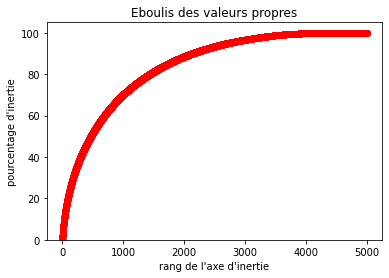

In [37]:
from sklearn import decomposition
from sklearn import preprocessing


# choix du nombre de composantes à calculer


# préparation des données pour l'ACP
X = df_bowcv.values
features = df_bowcv.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaledcv = std_scale.transform(X)

# Calcul des composantes principales
pcacv = decomposition.PCA()
pcacv.fit_transform(X_scaledcv)

# Eboulis des valeurs propres
display_scree_plot(pcacv)

plt.show()

ACP pour le bag of words Tf-idf

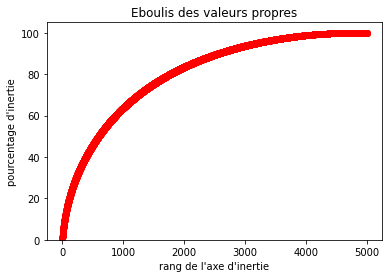

In [38]:
from sklearn import decomposition
from sklearn import preprocessing


# choix du nombre de composantes à calculer


# préparation des données pour l'ACP
X = df_bowctf.values
features = df_bowctf.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaledctf = std_scale.transform(X)

# Calcul des composantes principales
pcactf = decomposition.PCA()
pcactf.fit_transform(X_scaledctf)

# Eboulis des valeurs propres
display_scree_plot(pcactf)

plt.show()

## Export du DataFrame

In [39]:
data_T.dropna(axis=0,inplace=True)

In [40]:
data_T.isnull().mean()

Title               0.0
Body                0.0
Tags                0.0
sentence_bow        0.0
sentence_bow_lem    0.0
sentence_dl         0.0
tags                0.0
keywords_bow        0.0
keywords_bow_lem    0.0
keywords_dl         0.0
length_bow          0.0
length_bow_lem      0.0
length_dl           0.0
dtype: float64

In [41]:
data_T.to_csv('C://Users//antoi//Dropbox//PC//Desktop//Projet 5//data_T.csv')

In [ ]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook(local=True)


vis=gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.show(vis,local=False)

C:\Users\antoi\PycharmProjects\Projet 5\venv\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
C:\Users\antoi\PycharmProjects\Projet 5\venv\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


Serving to http://127.0.0.1:8891/    [Ctrl-C to exit]


127.0.0.1 - - [04/Jul/2022 22:50:14] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/Jul/2022 22:50:14] code 404, message Not Found
127.0.0.1 - - [04/Jul/2022 22:50:14] "GET /favicon.ico HTTP/1.1" 404 -
